This notebook provides scripts for supervised fine-tuning (SFT) the reward model (RM). It includes four steps: embeddings preparation, cross validation, training and fine-tuning. Here, we utilize the prepared DMS data of a target protein (NUDT15) in the paper as an example for SFT.

In [1]:
import os
import sys
sys.path.insert(0, '../relavdep')
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils import *
from scripts.models import *

## Step 1: Embeddings preparation

To train the reward model, we first need to generate mutant sequence embeddings by performing inference with SPIRED/ESM-2.

In [2]:
# prepared files
fasta_file = '../relavdep/data/fasta/NUDT15.fasta'
mutant_file = '../relavdep/data/fitness/NUDT15.csv'

# define parameters
output_path = '../relavdep/supervised/NUDT15'
os.makedirs(output_path, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
target, wt_seq = read_fasta(fasta_file)

raw_data = pd.read_csv(mutant_file)
targets = [target] + list(raw_data['mutant'])
sequences = [wt_seq] + list(raw_data['sequence'])

os.makedirs(os.path.join(output_path, 'embeddings'), exist_ok=True)

# initialize the base model
base_model = BaseModel(data_dir='../relavdep/data/params', device=device)

In [4]:
for i in tqdm(range(len(targets))):
    name = targets[i]
    seq = sequences[i]
    mut_data = base_model.inference(seq)
    mut_data = dict_to_device(mut_data, 'cpu')
    torch.save(mut_data, os.path.join(output_path, f'embeddings/{name}.pt'))

100%|██████████| 2845/2845 [19:34<00:00,  2.42it/s]


## Step 2: Cross validation

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

#### key parameters

- `fasta_file`: Wild-type protein sequence
- `mutant_file`: Mutation data
- `embedding_path`: Directory for DHR embeddings
- `output_path`: Output directory
- `rm_type`: Reward model type (fitness or stab)

#### structure of the current project

```
RelaVDEP
├── figures
├── notebook
│   ├── 1_prepare.ipynb
│   ├── 2_train_rm.ipynb (We are here)
├── relavdep 
│   ├── data
│   │   ├── fasta
│   │   │   ├── NUDT15.fasta (fasta_file)
│   │   ├── fitness
│   │   │   ├── NUDT15.csv (mutant_file)
│   ├── supervised (Run command here)
│   │   ├── NUDT15 (output_path)
│   │   │   ├── embeddings (embedding_path)
│   │   ├── cross_val.py (Run this script)
├── environment.yml
├── README.md
```

Run `cross_val.py` in `supervised/` directory as follows:

```
python cross_val.py --fasta ../data/fasta/NUDT15.fasta --mutant ../data/fitness/NUDT15.csv --embedding NUDT15/embeddings --output NUDT15 --rm_type fitness --batch_size 24 --device cuda
```

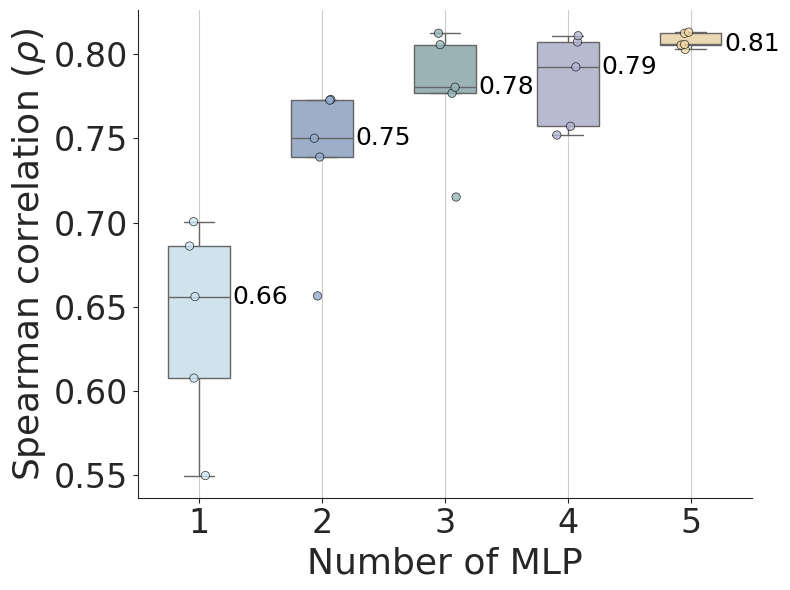

In [6]:
n_layers = [1, 2, 3, 4, 5]
n_fold = 5

result = pd.DataFrame()
calculate = pd.DataFrame()

for n in range(len(n_layers)):
    for k in range(n_fold):
        tmp = pd.read_csv(os.path.join(output_path, f'CV/layer_{n+1}/fold_{k}.csv'))
        result.loc[n * n_fold + k, 'Spearman correlation'] = -tmp.loc[tmp['Val'].argmin(), 'Test']
        result.loc[n * n_fold + k, 'Number of layers'] = str(n+1)
        calculate.loc[f'fold-{k}', f'num_layer-{n+1}'] = -tmp.loc[tmp['Val'].argmin(), 'Test']

sns.set_style('ticks')
plt.rcParams.update({
    'font.sans-serif': ['DejaVu Sans'],
    'axes.titlesize': 28,
    'axes.labelsize': 26,
    'xtick.labelsize': 24, 
    'ytick.labelsize': 24,
    'savefig.bbox': 'tight',
    'savefig.transparent': False
})

fig, ax = plt.subplots(figsize=(8, 6))
custom_colors = ['#cbe5f2', '#95adcf', '#98b7ba', '#b4b6d4', '#f3dba9']

sns.stripplot(x='Number of layers', y='Spearman correlation', 
              data=result, hue='Number of layers', jitter=True, 
              size=6, alpha=0.8, edgecolor='black', linewidth=0.5, 
              palette=custom_colors)

sns.boxplot(x='Number of layers', y='Spearman correlation', 
            data=result, hue='Number of layers', showfliers=False, 
            width=0.5, palette=custom_colors)

for index, value in enumerate(calculate.describe().loc['50%']):
    ax.text(x=index + 0.5, y=value, s='{:.2f}'.format(value),
            color='black', fontsize=18, va='center', ha='center')

ax.xaxis.grid(True)
ax.set(xlabel='Number of MLP', ylabel=r'Spearman correlation ($\rho$)')
sns.despine()
plt.tight_layout()
plt.show()

In [7]:
best_idx = np.argmax(calculate.describe().loc['50%'])
best_layer = n_layers[best_idx]
best_value = calculate.describe().loc['50%'][best_idx]

print(f"Best layer: {best_layer} | Spearman correlation: {best_value:.2f}")

Best layer: 5 | Spearman correlation: 0.81


## Step 3: Training

After determining the best number of MLP layers through cross-validation. Then train the reward model as follows:
```
python train.py --fasta ../data/fasta/NUDT15.fasta --mutant ../data/fitness/NUDT15.csv --embedding NUDT15/embeddings --output NUDT15 --rm_type SmallFitness --batch_size 24 --device cuda
```

## Step 4: Fine-tune

After pre-training the reward model, freeze most parameters and fine-tune the coefficient and bias as follows:
```
python train.py --fasta ../data/fasta/NUDT15.fasta --mutant ../data/fitness/NUDT15.csv --embedding NUDT15/embeddings --output NUDT15 --rm_type SmallFitness --batch_size 24 --device cuda --finetune --lr 1e1
```